<a href="https://colab.research.google.com/github/sztahodavid/humanaicourse/blob/main/emotion_recognition_speech_xvector_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ebben a Demo-ban az érzelmek felismerésével ismerkedhetünk meg beszédből. Az adatbázis 38 beszélőt tartalmaz, akik magyar nyelven a "Kovács Katival szeretnék beszélni" szöveget monták be 8 érzelmi állapot imitálásával. Ezen érzelmek a szomorúság, harag, félelem, izgatottság, undor, megelettség, öröm és semeleges. Jelen esetben a jellzőkinyerést egy mély tanuló algoritmussal végezzük.

Az első lépés a *szükséges csomagok* betöltése.

In [1]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

In [2]:
%%capture
# For pip installation
!pip install speechbrain

In [3]:
import os
import pandas as pd
import numpy as np
import torchaudio
import matplotlib.pyplot as plt

from speechbrain.pretrained import EncoderClassifier

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.manifold import TSNE

<ipython-input-3-351e4b7a9b99>:7: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


A jellemzőkinyerő modellt (x-vector) a SpeechBrain csomagból hívjuk meg.

In [5]:
# classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", run_opts={"device":"cuda"})
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb")

Ezután az elérési utat adjuk meg az adatbázishoz. Az adatbázist szűrjük a fent leírt beszédmintákra (magyar nyelv és 1. feladat). A célcímkéket eltárolkjuk a *labels* változóban.

In [6]:
!wget http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
!unzip HungarianEmotionalSentences.zip

--2024-11-20 22:31:55--  http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62600577 (60M) [application/x-zip-compressed]
Saving to: ‘HungarianEmotionalSentences.zip’

HungarianEmotionalS 100%[===================>]  59.70M  6.39MB/s    in 9.2s    

2024-11-20 22:32:06 (6.52 MB/s) - ‘HungarianEmotionalSentences.zip’ saved [62600577/62600577]

Archive:  HungarianEmotionalSentences.zip
  inflating: readme.txt              
  inflating: F0001B_hu.wav           
  inflating: F0001D_hu.wav           
  inflating: F0001I_hu.wav           
  inflating: F0001L_hu.wav           
  inflating: F0001M_hu.wav           
  inflating: F0001O_hu.wav           
  inflating: F0001S_hu.wav           
  inflating: F0002B_hu.wav           
  inflating: F0002D_hu.wav           
  inflating: F0002F_hu.wav  

In [7]:
!ls

CITATION.cff   F2041I_hu.wav  F3023S_hu.wav		       M0061F_hu.wav  M2092S_hu.wav
conftest.py    F2041L_hu.wav  F3031D_hu.wav		       M0061I_hu.wav  M2093B_hu.wav
docs	       F2041M_hu.wav  F3031F_hu.wav		       M0061L_hu.wav  M2093D_hu.wav
F0001B_hu.wav  F2041O_hu.wav  F3031I_hu.wav		       M0061M_hu.wav  M2093F_hu.wav
F0001D_hu.wav  F2041S_hu.wav  F3031L_hu.wav		       M0061O_hu.wav  M2093I_hu.wav
F0001I_hu.wav  F2042B_hu.wav  F3031M_hu.wav		       M0061S_hu.wav  M2093M_hu.wav
F0001L_hu.wav  F2042D_hu.wav  F3031O_hu.wav		       M0062B_hu.wav  M2093O_hu.wav
F0001M_hu.wav  F2042I_hu.wav  F3031S_hu.wav		       M0062D_hu.wav  M2093S_hu.wav
F0001O_hu.wav  F2042L_hu.wav  F3032B_hu.wav		       M0062F_hu.wav  M4001B_hu.wav
F0001S_hu.wav  F2042O_hu.wav  F3032F_hu.wav		       M0062I_hu.wav  M4001D_hu.wav
F0002B_hu.wav  F2042S_hu.wav  F3032L_hu.wav		       M0062L_hu.wav  M4001I_hu.wav
F0002D_hu.wav  F2043B_hu.wav  F3032M_hu.wav		       M0062M_hu.wav  M4001L_hu.wav
F0002F_hu.wav  F2043D_hu.wav  F

In [8]:
DATA_PATH = "/content/speechbrain/"

file_names = sorted(i for i in os.listdir(DATA_PATH) if i.endswith("_hu.wav") and i[4] == '1')
file_paths = [os.path.join(DATA_PATH, name) for name in file_names]

labels = []
names = []

for name in file_names:
    labels.append(name.split(".")[0].split("_")[0][-1])
    names.append(name.split((".")[0].split("_")[0][-1]))
print(len(labels))
print(len(names))

262
262


A címkék a *my_dict* szerinti egy betűs kódolásban vannak a labels *változóban*. Ezeket átalakítjuk számunkra értelmezhetőbb címkékké.

In [9]:
my_dict = {
    'B': "sadness",
    'D': "anger",
    'F': "fear",
    'I': "excitement",
    'L': "disgust",
    'M': "suprise",
    'O': "joy",
    'S': "neutral"
}

for i in range(len(labels)):
    if labels[i] in my_dict:
        labels[i] = my_dict[labels[i]]

A követkző cellában az embedding modell segítségével kinyerjük a jellemzőket. A jellemzőkinyerő algoritmus a pytorch keretrendszerben fut.

In [10]:
embeddings_list = []

for i, file_name in enumerate(file_paths):
    signal, fs = torchaudio.load(file_name)
    embeddings = classifier.encode_batch(signal)
    embeddings_list.append(embeddings.cpu().numpy())

embeddings_array = np.squeeze(np.array(embeddings_list))
print("Shape of array: ", embeddings_array.shape)

Shape of array:  (262, 512)


A kapott jellemzőket standarizáljuk (z = (x - átlag) / szórás) és eltároljuk az *X* változóban. A címkéket egy *y* tömbben tároljuk el.

In [11]:
scaler = StandardScaler()
scaler.fit(embeddings_array)
X = scaler.transform(embeddings_array)
print(X.shape)

y = np.array(labels)
print(y.shape)

(262, 512)
(262,)


Support Vektor Gép modellt fogunk taníani és tesztelni. Ehhez teljes keresztvalidációs eéjárást alkalmazunk, ahol mindig egy elem a teszt elem, a maradék pedig a tanító halmaz. Ez ismétlődik, amíg az összes elem nem volt tesztelem. Tesztelés során  a minta eredeti címkéjét (*orig*) és a bescült címkét (*pred*) eltároljuk.

In [12]:
loo = LeaveOneOut()
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', C=1, probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.append(y_test[0])
    pred.append(y_pred)

Végül egy *tévesztési mátrixon* és egy *reporton* keresztül vizsgálhatjuk a modellek teljesítményét.

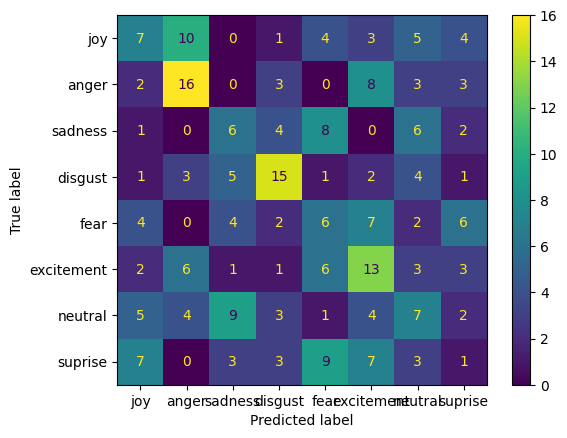

In [13]:
cm = metrics.confusion_matrix(orig, pred, labels=list(set(labels)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [14]:
print(metrics.classification_report(orig, pred, target_names=list(set(labels))))

              precision    recall  f1-score   support

         joy       0.41      0.46      0.43        35
       anger       0.47      0.47      0.47        32
     sadness       0.30      0.37      0.33        35
     disgust       0.17      0.19      0.18        31
        fear       0.24      0.21      0.22        34
  excitement       0.21      0.20      0.21        35
     neutral       0.21      0.22      0.22        27
     suprise       0.05      0.03      0.04        33

    accuracy                           0.27       262
   macro avg       0.26      0.27      0.26       262
weighted avg       0.26      0.27      0.26       262



Vizuális betekintést tehetünk a jellemzők szeparációs képességébe úgy, hogy dimenziójukat lecsökkentjük (ábrázolható mennyiségre) a minták egymáshoz képesti távolságuk megtartása mellett (t-SNE: t-distributed stochastic neighbor embedding). Az ábrázoláshoz az érzelmeket színkódoljuk egy szótár segítségével.

(-41.937188911437985,
 48.308973121643064,
 -40.566871070861815,
 36.8581880569458)

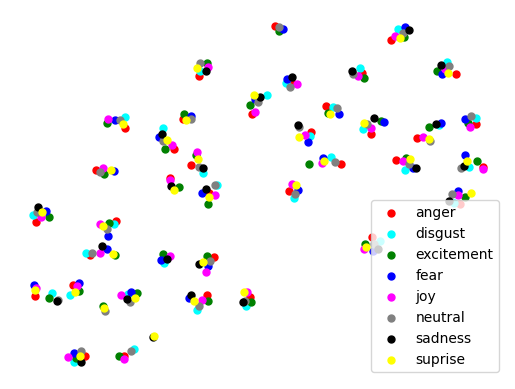

In [15]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

cdict = {
    "sadness": 'black',
    "anger": 'red',
    "fear": 'blue',
    "excitement": 'green',
    "disgust": 'cyan',
    "suprise": 'yellow',
    "joy": 'magenta',
    "neutral": 'gray'
}

for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[g], label = g, s = 25)
plt.legend()
plt.axis('off')

Modell fine-tuning

In [17]:
from speechbrain.inference.speaker import SpeakerRecognition
# verification_model = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", run_opts={"device":"cuda"}, savedir="./pretrained_xvect", hparams_file="hyperparams.yaml")
verification_model = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="./pretrained_xvect", hparams_file="hyperparams.yaml")

/content/speechbrain/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)
/content/speechbr

create dataloder

In [23]:
class EmotionBrain(speechbrain.Brain):
    def compute_forward(self, batch, stage):
        """Runs all the computation of that transforms the input into the
        output probabilities over the N classes.
        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """

        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)

        # Compute features, embeddings, and predictions
        feats, lens = self.prepare_features(batch.sig, stage)
        # feats = self.modules.mean_var_norm(feats, lens)
        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)
        return predictions

    def prepare_features(self, wavs, stage):
        """Prepare the features for computation, including augmentation.
        Arguments
        ---------
        wavs : tuple
            Input signals (tensor) and their relative lengths (tensor).
        stage : sb.Stage
            The current stage of training.
        """
        wavs, lens = wavs

        # Add augmentation if specified. In this version of augmentation, we
        # concatenate the original and the augment batches in a single bigger
        # batch. This is more memory-demanding, but helps to improve the
        # performance. Change it if you run OOM.
        if stage == speechbrain.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                lens = torch.cat([lens, lens])

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, lens)

        # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        _, lens = batch.sig
        emotion, _ = batch.emotion_encoded

        # Concatenate labels (due to data augmentation)
        if stage == speechbrain.Stage.TRAIN and hasattr(self.modules, "env_corrupt"):
            emotion = torch.cat([emotion, emotion], dim=0)
            lens = torch.cat([lens, lens])

        # Compute the cost function
        # old loss for xvector recipe
        loss = self.hparams.compute_cost(predictions, emotion, lens)


        if stage == speechbrain.Stage.TRAIN and hasattr(
            self.hparams.lr_annealing, "on_batch_end"
        ):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        # Compute classification error at test time
        if stage != speechbrain.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, emotion, lens)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        # old xvector recipe
        # self.loss_metric = speechbrain.utils.metric_stats.MetricStats(
        #     metric=speechbrain.nnet.losses.nll_loss
        # )

        # Set up evaluation-only statistics trackers
        if stage != speechbrain.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        stage_stats = {"loss": stage_loss}
        if stage == speechbrain.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == speechbrain.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            speechbrain.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )
        # We also write statistics about test data to stdout and to the logfile.
        if stage == speechbrain.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats
            )

data generation

In [24]:
spkids = []
for i,e in enumerate(names):
  spkids.append(names[i][0][1:4])
spkids = np.unique(spkids)
print(spkids)
np.random.shuffle(spkids)
print(spkids)
print(len(spkids))
training, test, valid = spkids[:20], spkids[20:28], spkids[28:40]
print(len(training))
print(len(test))
print(len(valid))

json_data = {}
for i,e in enumerate(names):
  if (names[i][0][1:4] in training):
    json_data[i]={"emotion":labels[i],"path":"/content/speechbrain/"+names[i][0]+"."+names[i][1],"length":3,"spkId":names[i][0][1:4]}
print(json_data)
import json
with open("/content/speechbrain/train.json","w+") as f:
  f.write(json.dumps(json_data))
json_data = {}
for i,e in enumerate(names):
  if (names[i][0][1:4] in test):
    json_data[i]={"emotion":labels[i],"path":"/content/speechbrain/"+names[i][0]+"."+names[i][1],"length":3,"spkId":names[i][0][1:4]}
print(json_data)
import json
with open("/content/speechbrain/test.json","w+") as f:
  f.write(json.dumps(json_data))
json_data = {}
for i,e in enumerate(names):
  if (names[i][0][1:4] in valid):
    json_data[i]={"emotion":labels[i],"path":"/content/speechbrain/"+names[i][0]+"."+names[i][1],"length":3,"spkId":names[i][0][1:4]}
print(json_data)
import json
with open("/content/speechbrain/valid.json","w+") as f:
  f.write(json.dumps(json_data))


['000' '001' '002' '003' '004' '005' '006' '007' '100' '101' '102' '103'
 '104' '200' '201' '202' '203' '204' '205' '206' '207' '208' '209' '300'
 '301' '302' '303' '304' '400' '401' '402' '403' '404' '500' '501' '502'
 '503' '504']
['005' '100' '003' '200' '002' '203' '202' '301' '104' '502' '006' '303'
 '503' '207' '402' '103' '001' '302' '500' '208' '504' '204' '400' '004'
 '404' '000' '201' '403' '501' '304' '209' '401' '102' '101' '205' '007'
 '300' '206']
38
20
8
10
{15: {'emotion': 'sadness', 'path': '/content/speechbrain/F0051B_hu.wav', 'length': 3, 'spkId': '005'}, 16: {'emotion': 'anger', 'path': '/content/speechbrain/F0051D_hu.wav', 'length': 3, 'spkId': '005'}, 17: {'emotion': 'fear', 'path': '/content/speechbrain/F0051F_hu.wav', 'length': 3, 'spkId': '005'}, 18: {'emotion': 'excitement', 'path': '/content/speechbrain/F0051I_hu.wav', 'length': 3, 'spkId': '005'}, 19: {'emotion': 'disgust', 'path': '/content/speechbrain/F0051L_hu.wav', 'length': 3, 'spkId': '005'}, 20: {'emo

In [25]:
import speechbrain
import torch
from torch.utils.data import DataLoader
# from speechbrain.dataio.sampler import DynamicBatchSampler
# from speechbrain.dataio.batch import PaddedBatch
# Initialization of the label encoder. The label encoder assignes to each
# of the observed label a unique index (e.g, 'spk01': 0, 'spk02': 1, ..)
label_encoder = speechbrain.dataio.encoder.CategoricalEncoder()

# Define audio pipeline
@speechbrain.utils.data_pipeline.takes("path")
@speechbrain.utils.data_pipeline.provides("sig")
def audio_pipeline(path):
    """Load the signal, and pass it and its length to the corruption class.
    This is done on the CPU in the `collate_fn`."""
    sig = speechbrain.dataio.dataio.read_audio(path)
    return sig

# Define label pipeline:
@speechbrain.utils.data_pipeline.takes("emotion")
@speechbrain.utils.data_pipeline.provides("emotion", "emotion_encoded")
def label_pipeline(emotion):
    yield emotion
    emotion_encoded = label_encoder.encode_label_torch(emotion)
    yield emotion_encoded

# Define length pipeline:
@speechbrain.utils.data_pipeline.takes("length")
@speechbrain.utils.data_pipeline.provides("length")
def length_pipeline(length):
    yield length

# Define datasets. We also connect the dataset with the data processing
# functions defined above.
datasets = {}
for dataset in ["train", "valid", "test"]:
    datasets[dataset] = speechbrain.dataio.dataset.DynamicItemDataset.from_json(
        json_path="/content/speechbrain/"+dataset+".json",
        dynamic_items=[audio_pipeline, label_pipeline, length_pipeline],
        output_keys=["id", "sig", "emotion_encoded", "length"]
    )
    datasets[dataset] = datasets[dataset].filtered_sorted(sort_key="length")
    # datasets[dataset].add_dynamic_item(speechbrain.dataio.dataio.read_audio, takes="path", provides="signal")

# # Creates dynamic batcher to
# sorted_data = datasets["train"].filtered_sorted(sort_key="length")
# n_buckets = 200
# batch_multiplier = 1.5

# # Setting batch bucket bounds manually. Values are in seconds.
# buckets_bounds = [0.01,0.2,0.5,1.0,2.0,4.0,6.0,8.0,10.0,15.0,20.0]

# #   Used for dynamic bucket bounds. Not used.
# # buckets_bounds = [0.199999]
# # for x in range(n_buckets):
# #     buckets_bounds.append(buckets_bounds[-1]*batch_multiplier)
# # buckets_bounds = [x for x in buckets_bounds if x < 20]


# dynamic_sampler = DynamicBatchSampler(
#     sorted_data,
#     max_batch_length=hparams["max_batch_len"],
#     bucket_boundaries=buckets_bounds,
#     length_func= lambda x: float(x["length"]),
#     shuffle=True,
#     batch_ordering="random",
#     drop_last=True,
#     verbose=False
# )

# dataloader_train = DataLoader(sorted_data,batch_sampler=dynamic_sampler,collate_fn=PaddedBatch)

# # Load or compute the label encoder (with multi-GPU DDP support)
# # Please, take a look into the lab_enc_file to see the label to index
# # mappinng.
lab_enc_file = "/content/speechbrain/label_encoder.txt"
label_encoder.load_or_create(
    path=lab_enc_file,
    from_didatasets=[datasets["train"]],
    output_key="emotion",
)


In [26]:
verification_model.mods

ModuleDict(
  (compute_features): Fbank(
    (compute_STFT): STFT()
    (compute_fbanks): Filterbank()
    (compute_deltas): Deltas()
    (context_window): ContextWindow()
  )
  (mean_var_norm): InputNormalization()
  (embedding_model): Xvector(
    (blocks): ModuleList(
      (0): Conv1d(
        (conv): Conv1d(24, 512, kernel_size=(5,), stride=(1,))
      )
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(
        (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Conv1d(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
      )
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm1d(
        (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (6): Conv1d(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
      )
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm1d(
        (norm): Ba

In [29]:
verification_model.hparams

namespace(n_mels=24,
          pretrained_path='speechbrain/spkrec-xvect-voxceleb',
          out_n_neurons=7205,
          compute_features=Fbank(
                             (compute_STFT): STFT()
                             (compute_fbanks): Filterbank()
                             (compute_deltas): Deltas()
                             (context_window): ContextWindow()
                           ),
          mean_var_norm=InputNormalization(),
          embedding_model=Xvector(
                            (blocks): ModuleList(
                              (0): Conv1d(
                                (conv): Conv1d(24, 512, kernel_size=(5,), stride=(1,))
                              )
                              (1): LeakyReLU(negative_slope=0.01)
                              (2): BatchNorm1d(
                                (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                              )
                              (

In [54]:
hparams = {
  # "augmentation": speechbrain.lobes.augment.TimeDomainSpecAugment(sample_rate=16000, speeds= [95, 100, 105]),
  "compute_cost": speechbrain.nnet.losses.LogSoftmaxWrapper(loss_fn=speechbrain.nnet.losses.AdditiveAngularMargin),
  "compute_error": speechbrain.nnet.losses.classification_error,
  "lr_annealing": speechbrain.nnet.schedulers.CyclicLRScheduler(base_lr= 0.00000001, max_lr= 0.001, step_size= 6500),
  "error_stats": speechbrain.utils.metric_stats.MetricStats(metric=speechbrain.nnet.losses.classification_error)
}

model = speechbrain.lobes.models.Xvector.Xvector(
    in_channels=24,
    activation=torch.nn.LeakyReLU,
    tdnn_blocks=5,
    tdnn_channels=[512, 512, 512, 512, 1500],
    tdnn_kernel_sizes=[5, 3, 3, 1, 1],
    tdnn_dilations=[1, 2, 3, 1, 1],
    lin_neurons=512)

from speechbrain.utils.parameter_transfer import Pretrainer

# Initialization of the pre-trainer
pretrain = Pretrainer(loadables={'model': model}, paths={'model': 'speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'})

# We download the pretrained model from HuggingFace in this case
pretrain.collect_files()
pretrain.load_collected()

emotion_brain = EmotionBrain(
    modules=model.modules.mods,
    opt_class=lambda x: torch.optim.Adam(x, lr=0.001,weight_decay=0.000002),
    hparams=hparams
    # run_opts=run_opts,
    # checkpointer=hparams["checkpointer"]
)

/content/speechbrain/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)


AttributeError: 'function' object has no attribute 'mods'

In [56]:
verification_model.mods

ModuleDict(
  (compute_features): Fbank(
    (compute_STFT): STFT()
    (compute_fbanks): Filterbank()
    (compute_deltas): Deltas()
    (context_window): ContextWindow()
  )
  (mean_var_norm): InputNormalization()
  (embedding_model): Xvector(
    (blocks): ModuleList(
      (0): Conv1d(
        (conv): Conv1d(24, 512, kernel_size=(5,), stride=(1,))
      )
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(
        (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Conv1d(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
      )
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm1d(
        (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (6): Conv1d(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
      )
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm1d(
        (norm): Ba